In [1]:
import casadi as ca
import casadi.tools as cat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import networkx as nx
import sys, copy
from scipy.integrate import solve_ivp
import matlab.engine

sys.path.append('.')
sys.path.append('ocp-solving/')

#from COVIDVaccinationOCP import COVIDVaccinationOCP, rk4_mob, rhs_py_total, rhs_py
from ItalySetup import ItalySetup

from utils import *

eng = matlab.engine.start_matlab()
eng.cd('geography-paper-master/', nargout=0)
eng.run('single_build.m', nargout=0)

model_size = 10

s = ItalySetup(model_size)

N = 163           # Number of control time interval
T = 163#52 * 7       # N * 7
n_int_steps = 1

model_days = pd.date_range(s.start_date, s.end_date, freq='1D')
freq = '1D'  # 'W-MON'
model_step = pd.date_range(s.start_date, s.end_date, freq=freq)
mobintime = s.mobility_ts.resample(freq).mean()

N = len(model_step) - 1
T = len(model_days)

nx = 9

pnames = 1

states_list = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
states = states_list

S, E, P, I, A, Q, H, R, V = np.arange(nx)

integ_matlab = np.array(eng.eval('x'))

p_dict, mobfrac, mobmat, betaratiointime, x0= get_parameters_from_matlab(eng, s, model_size, model_days, freq)

dt = T / N / n_int_steps

obj_params = {
    'scale_ell': 1e0,
    'scale_If': 1e2,
    'scale_v': 1e-6
}
betaP0 = p_dict['betaP0']
epsilonA = p_dict['epsilonA']
epsilonI = p_dict['epsilonI']
r = p_dict['r']

p_dict.pop('betaP0')
p_dict.pop('r')
p_dict.pop('epsilonA')
p_dict.pop('epsilonI')
C = mobmat

Loaded Italy Setup with 10 nodes.


In [2]:

def rhs_py(t, x, u, cov, p, mob, pop_node):
    S, E, P, I, A, Q, H, R, V = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    deltaE, deltaP,sigma,eta,gammaI,gammaA,gammaQ,gammaH,alphaI,alphaH, zeta,  gammaV = \
    p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11]
   
    v = u[0]
    foi = mob
    rhs = [None] * nx
    v = 0
    vaccrate = v / (S + E + P + A + Q + H + R+1)  # NOT I NOT H ?
    #num = S + E + P + A + Q + H + R
    #vaccrate = v / (sqrt(num**2 + 1e3))   # is 1e7 too large
    rhs[0] = -(foi + vaccrate) * S + gammaV * V  # S
    rhs[1] = foi * S - deltaE * E;  # E
    rhs[2] = deltaE * E - deltaP * P;  # P
    rhs[3] = sigma * deltaP * P - (eta + gammaI + alphaI) * I;  # I
    rhs[4] = (1 - sigma) * deltaP * P - gammaA * A;  # A
    rhs[5] = zeta * eta * I - gammaQ * Q;  # Q
    rhs[6] = (1 - zeta) * eta * I - (gammaH + alphaH) * H;  # H
    rhs[7] = gammaI * I + gammaA * A + gammaH * H + gammaQ * Q;  # R
    rhs[8] = vaccrate * S - gammaV * V  # V
    rhs_ell = [None] * 3
    rhs_ell[0] = gammaH * H;  # recovered from the hospital
    rhs_ell[1] = alphaH * H;  # total death
    rhs_ell[2] = (1 - zeta) * eta * I;  # cumulative hospitalized cases

    return rhs, rhs_ell

In [3]:
setup = s
model_params = copy.copy(p_dict)
ind2name = setup.ind2name
#ind_to_plot = setup.ind_to_plot
pop_node = setup.pop_node

M = setup.nnodes
mobility = setup.mobility

print(f'Building OCP with {M} nodes')

c = setup.mobility

scale_ell = obj_params['scale_ell']
scale_If = obj_params['scale_If']
scale_v = obj_params['scale_v']
pnum = params_to_vector(model_params)

pnum.append(scale_ell)
pnum.append(scale_If)
pnum.append(scale_v)

# ---- decision variables ---------
states = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
states = cat.struct_symSX(states)
[S, E, P, I, A, Q, H, R, V] = states[...]

controls = cat.struct_symSX(['v', 'mob'])
[v, mob] = controls[...]

covar = cat.struct_symSX(['J'])
[J] = covar[...]

params = cat.struct_symSX(list(model_params.keys()) + ['scale_ell', 'scale_If', 'scale_v'])
[deltaE, deltaP, sigma, eta, gammaI, gammaA, gammaQ, gammaH, alphaI, alphaH, zeta, gammaV,
 scale_ell, scale_If, scale_v] = params[...]

pop_nodeSX = ca.SX.sym('pop_node')


# The rhs is at time zero, the time is also no used in the equation so that exoplain
rhs, rhs_ell = rhs_py(0, states.cat, controls.cat, covar.cat, params.cat, mob, pop_nodeSX)
rhs = ca.veccat(*rhs)


rhs_ell = ca.veccat(*rhs_ell)  # mod

Building OCP with 10 nodes


In [4]:
frhs = ca.Function('frhs', [states, controls, covar, params, pop_nodeSX],
                           [rhs, scale_ell * rhs_ell[1] + scale_v * v * v])# mod

dt = T / N / n_int_steps  # length of an integration interval
# ---- dynamic constraints --------
k1, k1ell = frhs(states, controls, covar, params, pop_nodeSX)
k2, k2ell = frhs(states + dt / 2 * k1, controls, covar, params, pop_nodeSX)
k3, k3ell = frhs(states + dt / 2 * k2, controls, covar, params, pop_nodeSX)
k4, k4ell = frhs(states + dt * k3, controls, covar, params, pop_nodeSX)
x_next = states + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
ell_next = dt / 6 * (
        k1ell + 2 * k2ell + 2 * k3ell + k4ell)  # No need for because we sum it week by week few lines below.

rk4_step = ca.Function('rk4_step', [states, controls, covar, params, pop_nodeSX], [x_next, ell_next])

In [5]:
x_ = ca.veccat(*states[...])
ell = 0.
# x_eul = x_ + dt*k1
for k in range(n_int_steps):
    x_, ell_ = rk4_step(x_, controls, covar, params, pop_nodeSX)
    ell += ell_

rk4_int = ca.Function('rk4_int', [states, ca.veccat(controls, covar, params, pop_nodeSX)], [x_, ell],
                      ['x0', 'p'], ['xf', 'qf'])

# BUG TODO Isn't this a double multiplication by the scale parameter since ell is already multiplied ?
ell = ca.Function('ell', [states, controls, covar, params, pop_nodeSX],
                  [scale_ell * ell + scale_v * v * v, scale_ell * ell,
                   scale_v * v * v])  # Very dependent on regularization factor


In [6]:
Vars = cat.struct_symMX([
    (
        cat.entry("x", struct=states, repeat=[M, N + 1]),
        cat.entry("u", struct=controls, repeat=[M, N]),
    ),
])

Params = cat.struct_symMX([
    (
        cat.entry("cov", struct=covar, repeat=[M, N]),  # TODO BUG this make the rainfall weekly !
        cat.entry("p", struct=params),
    ),
])


In [7]:
Params.cat

MX(V)

In [8]:
N+1

164

In [9]:
lbx = Vars(-np.inf)
ubx = Vars(np.inf)

f = 0
vaccines = 0
cases = 0
reg = 0
cdot_T = 0
dyn = [None] * M
spatial = [None] * M
for i in range(M):
    print(f'{i}:', end='')
    dyn[i] = []
    spatial[i] = []
    for k in range(N):
        
        mobK = mobintime.to_numpy().T[:,k]
        betaR = betaratiointime.to_numpy().T[:,k]
        C = r*mobfrac.flatten()*mobK*mobmat
        np.fill_diagonal(C,1-C.sum(axis=1)+ C.diagonal())

        [X_, ell_ik] = rk4_int(Vars['x', i, k],
                               ca.veccat(Vars['u', i, k], Params['cov', i, k], Params['p'], pop_node[i]))
        dyn[i].append(Vars['x', i, k + 1] - X_)
        ell_ik_, cases_ik, reg_ik = ell(Vars['x', i, k], Vars['u', i, k], Params['cov', i, k], Params['p'],
                                        pop_node[i])
        f += ell_ik
        cases += cases_ik
        reg += reg_ik

        #mob_ik = sum(c[i, j] * Vars['x', j, k, 'S'] / (1 + Vars['x', j, k, 'S']) for j in range(M)) # TODO WRONG
         #foi=C@((C.T@(betaP0*betaR*(X[:,P]+epsilonA*X[:,A]))+epsilonI*betaP0*betaR*X[:,I])/ \
         #(C.T@(X[:,S]+X[:,E]+X[:,P]+X[:,R]+X[:,A])+X[:,I]))           # TODO V here
       
        
        Sk, Ek, Pk, Rk, Ak, Ik = Vars['x', :, k, 'S'], Vars['x', :, k, 'E'], Vars['x', :, k, 'P'], \
                           Vars['x', :, k, 'R'], Vars['x', :, k, 'A'], Vars['x', :, k, 'I']

        mob_ik = sum(C[i, m] * (
                    (sum(C[n, i] * (betaP0*betaR[n]*(Pk[n]+epsilonA*Ak[n])) for n in range(M)) + epsilonI*betaP0*betaR[i]*Ik[i]) /
                    (sum(C[l, i]*(Sk[l]+Ek[l]+Pk[l]+Rk[l]+Ak[l]) for l in range(M)) + Ik[i]))
                     for m in range(M))
        
        
        
        
        spatial[i].append(Vars['u', i, k, 'mob'] - mob_ik) # spatial, vaccines and dyn are put in g(x), with constraints that spatial and dyn are equal to zero
        # thus imposing the dynamics and coupling.
        vaccines += Vars[ 'u', i, k, 'v'] * T / N  # Number of vaccine spent = num of vaccine rate * 7 (number of days)

f /= T  # Average over interval for cost ^ but not terminal cost 

0:1:2:3:4:5:6:7:8:9:

In [10]:
type(mob_ik)

casadi.casadi.MX

In [11]:
g = cat.struct_MX([
    cat.entry("dyn", expr=dyn),
    cat.entry("spatial", expr=spatial),
    cat.entry("vaccines", expr=vaccines),
])

costTerms = ca.Function('costTerms', [Vars, Params], [cases, reg])


# This initialize
lbg = g(0)
ubg = g(0)


ubg['vaccines'] = 100000. * M
lbg['vaccines'] = -np.inf

optimize = 0
lbx['u', :, :, 'v'] = 0.
ubx['u', :, :, 'v'] = 15000 * optimize  # = 0 if we don't want to optimize
# ubx['u',:,:,'v'] = 0
ubx['u', :, :1, 'v'] = 0.

# Set initial conditions as constraints
for cp, name in enumerate(states.keys()):
    for i in range(M):
        lbx['x', i, 0, name] = ubx['x', i, 0, name] = x0[i*nx+cp]

# NLOP arguments:
# 'x' : variable names to optimize: here states and control
# 'p' : params that can be change after
# 'f' is the objective function of 'x', that we ought to minize
# 'g' is a function that goes lbg < g(x,p) < ubg. If you want equality constraint then ubg = lbg = the number yoiu want it to be.
nlp = {'x': Vars, 'p': Params, 'f': f, 'g': g}
nlpFun = ca.Function('nlpFun', [Vars, Params], [f, g])
nlpJac = nlpFun.factory('nlpJac', ['i0', 'i1'], ['jac:o1:i0'])



options = {}
options['ipopt'] = {}
options['ipopt']["linear_solver"] = "ma57"
# options['ipopt']["linear_solver"] = "ma86"
# options['ipopt']["linear_solver"] = "ma97"
# options['ipopt']['bound_frac'] = 1e-4
# options['ipopt']['bound_push'] = 1e-4
# options['ipopt']['slack_bound_frac'] = 1e-4
# options['ipopt']['slack_bound_push'] = 1e-6
# options['ipopt']['hessian_constant'] = 'yes'
# options['ipopt']["tol"] = 1e-8

solver = ca.nlpsol('solver', "ipopt", nlp, options)

# options = {}
# options['ls_step_factor'] = 0.5
# options['pr_tol'] = 1e-8
# options['du_tol'] = 1e-8
# options['qp_solver'] = 'nlpsol'
# options['qp_solver_options']  = {'nlpsol':'ipopt','nlpsol_options':{'print_time':False,'ipopt.print_level':0,'ipopt.hessian_constant':'yes','ipopt.linear_solver':'ma97','ipopt.tol':1e-16}}
# # options['regularization'] = 'regularize_reduced'
# options['regularization'] = 'regularize_reduced_diag'
# options['regularization_tol'] = 1e-10
# options['linesearch'] = 'filter'
# options["iteration_callback"] = plotIterates
# self.solver = SQPmethod(nlp,options)




In [12]:
states.keys()

['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

In [13]:
integ_matlab = np.array(eng.eval('x'))

init = Vars(0)
for i, name in enumerate(states.keys()):
    for k in range(N + 1):
        # init['x',:,k,name] = sol0.y[i,k]
        for nd in range(M):
            init['x', nd, k, name] = integ_matlab.T[nd+107*i, k].T*0.9 # p['x0']  # self.ic[name][i]

init['u'] = 0.

arg = {}
arg['lbg'] = lbg
arg['ubg'] = ubg

arg['lbx'] = lbx
arg['ubx'] = ubx
arg['x0'] = init
arg['p'] = Params()
# for i in range(M):
#    for k in range(N):
#        arg['p']['cov',i,k] = rainfall_norm[i,k]**params(pnum)['r']
# arg['p']['cov',i,k] = np.random.random()**params(pnum)['r']

arg['p']['p'] = pnum

In [14]:
sol = solver(**arg)
opt = Vars(sol['x'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:   169470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   289990

Total number of variables............................:    16300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    16300
Total number of inequality constrai

In [15]:
3*9*164+2*163*3

5406

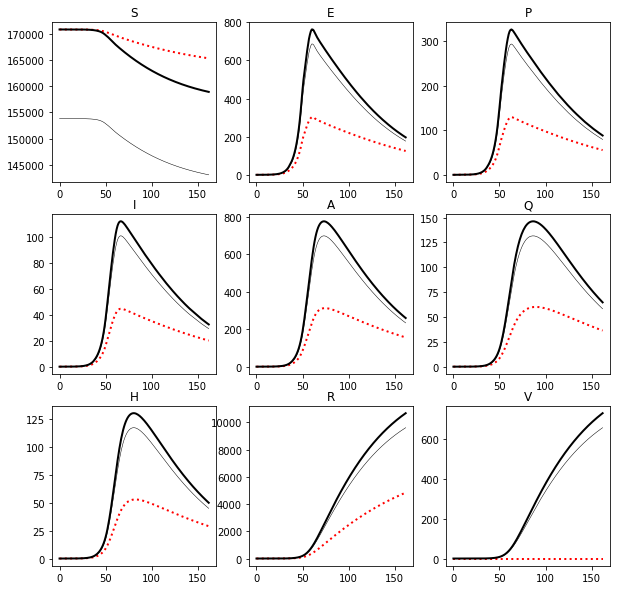

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(states_list)//3,3, figsize = (10,10))
node = 1
til = -1


for i, st in enumerate(states_list):
    axes.flat[i].plot(np.array(ca.veccat(*opt['x',node,:til,st])), 
                  linestyle=':', lw = 2, color='r')
    axes.flat[i].plot(np.array(integ_matlab.T[node+107*i,:til].T), 
                  linestyle='-', lw = 2, color='k')
    axes.flat[i].plot(np.array(integ_matlab.T[node+107*i,:til].T)*0.9, 
                  linestyle='-', lw = .5, color='k')
    axes.flat[i].set_title(st);




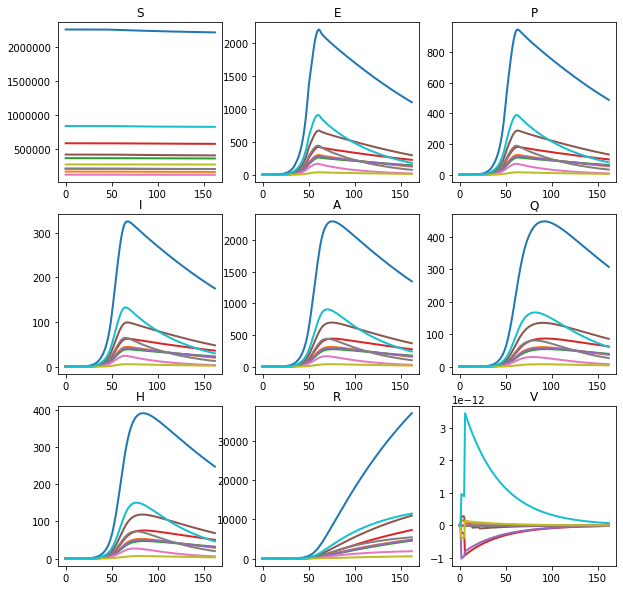

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(states_list)//3,3, figsize = (10,10))
node = 1
til = -1


for i, st in enumerate(states_list):
    for k in range(M):
        axes.flat[i].plot(np.array(ca.veccat(*opt['x',k,:til,st])), 
                   lw = 2)
        axes.flat[i].set_title(st);


